In [ ]:
########################################################################################
# checkout this resource : https://www.tensorflow.org/tutorials/load_data/images       #
#  This notebook contains a Convolution neural network for detecting mask on a person                             #
########################################################################################

########################################################################################
# new model is just 1.5 Mb                                                             #
########################################################################################

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2




In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
batch_size = 40
img_height = 200
img_width = 200


In [ ]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/face-mask-dataset/data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [ ]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/kaggle/input/face-mask-dataset/data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [ ]:
class_names = training_ds.class_names

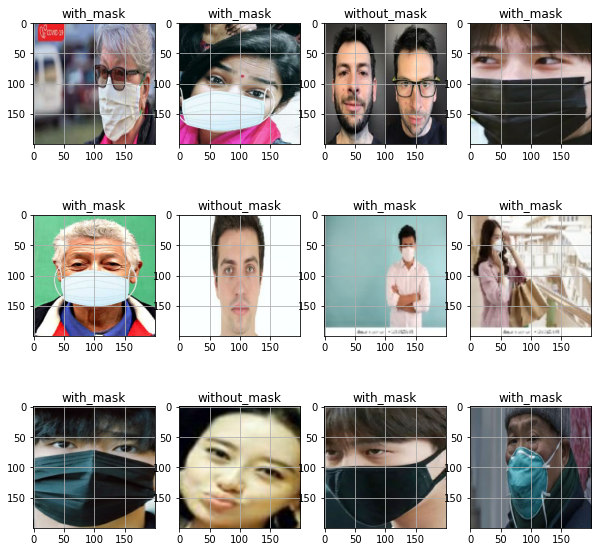

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [ ]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## lets define our CNN
MyCnn = tf.keras.models.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  # Some thing I realised just
  # using flatten layer will
  # increase the size of your
  # model, hence use
  # Global avg Pooling
  # instead
  # layers.Flatten(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

In [ ]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
## lets train our CNN
retVal = MyCnn.fit(training_ds, validation_data= testing_ds, epochs = 15)

Epoch 1/15
152/152 [==============================] - 20s 134ms/step - loss: 0.5860 - accuracy: 0.6950 - val_loss: 0.5807 - val_accuracy: 0.6689
Epoch 2/15
152/152 [==============================] - 5s 30ms/step - loss: 0.5421 - accuracy: 0.7283 - val_loss: 0.5332 - val_accuracy: 0.7272
Epoch 3/15
152/152 [==============================] - 5s 30ms/step - loss: 0.5224 - accuracy: 0.7460 - val_loss: 0.4769 - val_accuracy: 0.7801
Epoch 4/15
152/152 [==============================] - 5s 30ms/step - loss: 0.4934 - accuracy: 0.7625 - val_loss: 0.4271 - val_accuracy: 0.8093
Epoch 5/15
152/152 [==============================] - 5s 30ms/step - loss: 0.4369 - accuracy: 0.8047 - val_loss: 0.3647 - val_accuracy: 0.8430
Epoch 6/15
152/152 [==============================] - 5s 30ms/step - loss: 0.3711 - accuracy: 0.8484 - val_loss: 0.3087 - val_accuracy: 0.8775
Epoch 7/15
152/152 [==============================] - 5s 30ms/step - loss: 0.3374 - accuracy: 0.8645 - val_loss: 0.2857 - val_accuracy: 0.88

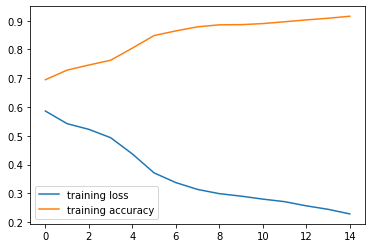

In [ ]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

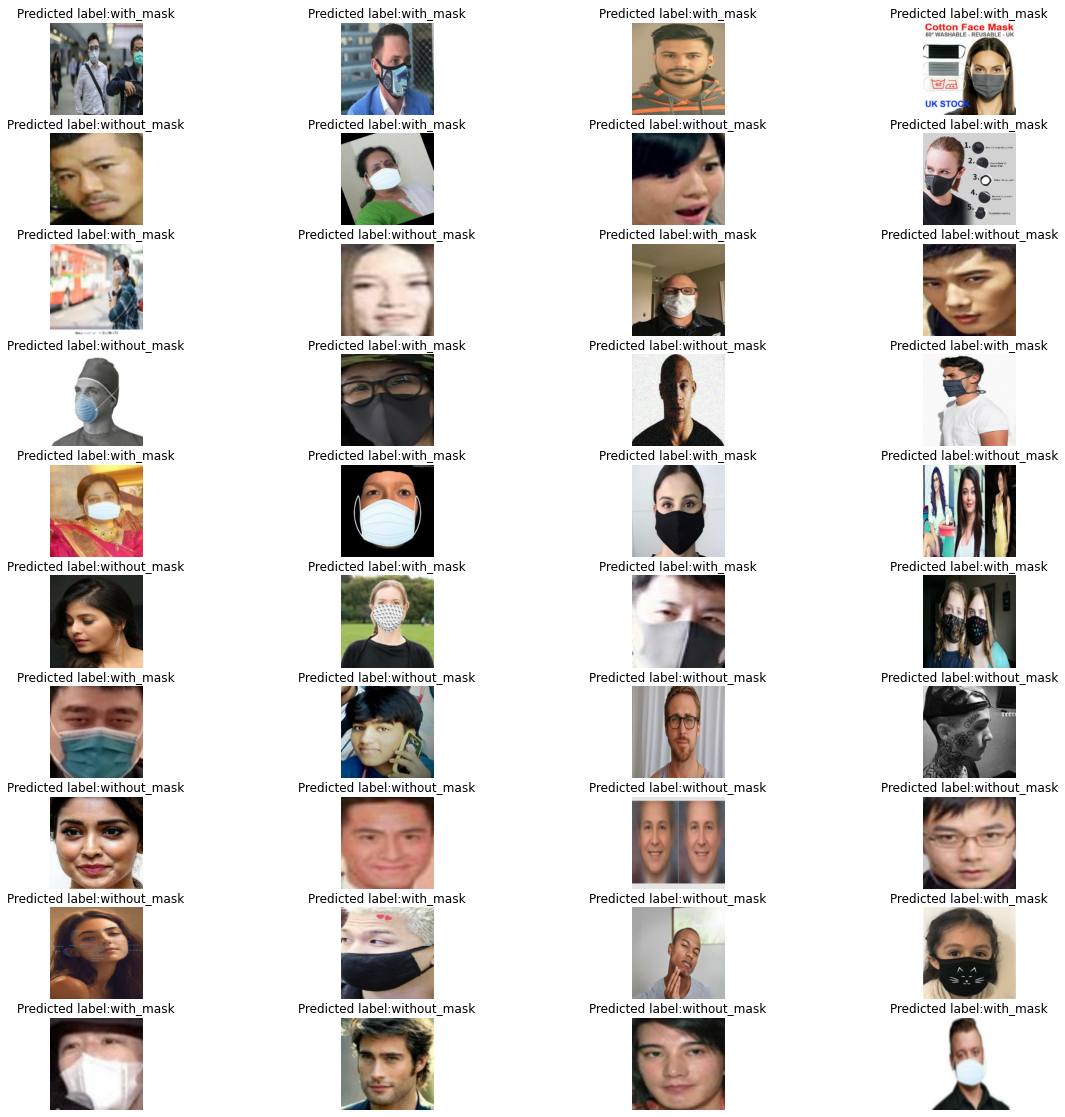

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)




In [ ]:
###############################################################################################
# object detection using sliding window approach                                              #
###############################################################################################

###############################################################################################
# This is just a demo for performance opt for RCNN and Faster RCNN architectures              #
###############################################################################################


def LoadAndDetectObject(path, boxSize = 100, lim = 200):
    img = plt.imread(path)
    img = cv2.resize(img,(200,200))
    numplots = (lim / boxSize)*(lim /boxSize)
    stride = int ((lim - boxSize)/ boxSize)

    xCurPos = 0
    yCurPos = 0
    Red = img [:,:,0]
    Blue = img[:,:,1]
    Green = img[:,:,2]

    y_pos = 0
    i = 0
    while y_pos < lim:
        x_pos = 0
        while x_pos < lim:
            xCurPos = x_pos
            yCurPos = y_pos
            i += 1
            if i > numplots + 1000:
                cv2.putText(img, 'No Mask', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                plt.imshow(img)
                return


            r = Red[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            g = Blue[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]
            b = Green[x_pos : (x_pos + boxSize), y_pos : (y_pos + boxSize)]

            ## sanity check
            xx, yy = r.shape
            if xx*yy != boxSize*boxSize:
                x_pos += stride
                continue

            imageSegment = cv2.merge((r,g,b))
            imageSegment  = np.array(imageSegment, dtype = 'uint8')
            imageSegment = cv2.resize(imageSegment, (lim, lim))
            result = (MyCnn.predict(np.array([imageSegment])))
            probab = max(result.flatten())
            result = (class_names[np.argmax(result)])
            #print(probab)

            if result == 'with_mask' and probab >= 0.8:
                probab = int (probab * 100) / 100
                img = cv2.rectangle(img, (xCurPos,yCurPos), (xCurPos + boxSize, yCurPos + boxSize), (0,255,0), 1)
                cv2.putText(img, 'Mask', (xCurPos,yCurPos + boxSize), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
                plt.imshow(img)
                return




            x_pos += stride
        y_pos += stride

    cv2.putText(img, 'No Mask', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    plt.imshow(img)




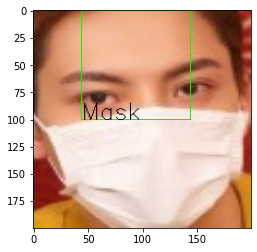

In [ ]:
LoadAndDetectObject('/kaggle/input/face-mask-dataset/data/with_mask/with_mask_1323.jpg')

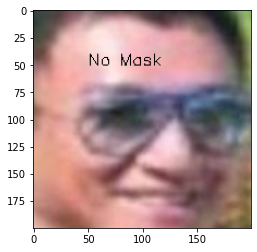

In [ ]:
LoadAndDetectObject('/kaggle/input/face-mask-dataset/data/without_mask/without_mask_536.jpg')

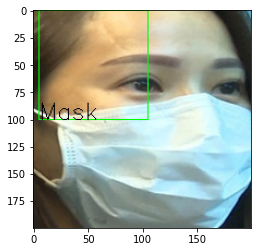

In [ ]:
LoadAndDetectObject('/kaggle/input/face-mask-dataset/data/with_mask/with_mask_439.jpg')

In [ ]:
MyCnn.save('maskDetector.h5')